In [1]:
# 1. Module Import 
import numpy as np                              # 선형대수를 위한 NumPy 라이브러리 불러오기
import matplotlib.pyplot as plt                 # 데이터 시각화를 위한 Matplotlib 라이브러리 불러오기

import torch                                    # PyTorch 라이브러리 불러오기 (딥러닝 프레임워크)
import torch.nn as nn                           # 신경망 모델 생성을 위한 모듈 불러오기
import torch.nn.functional as F                 # 활성화 함수 등 신경망 관련 주요 함수들 불러오기
from torchvision import transforms, datasets    # 이미지 데이터 전처리 및 데이터셋 다운로드를 위한 torchvision 모듈 불러오기

In [2]:
# 2. 딥러닝 모델을 설계할 때 활용하는 장비 확인 

if torch.cuda.is_available():                  # 만약 CUDA(GPU)가 사용 가능하면
    DEVICE = torch.device('cuda')              # 장치를 GPU로 설정
else: 
    DEVICE = torch.device('cpu')              # 그렇지 않으면 장치를 CPU로 설정

print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)  # 사용 중인 PyTorch 버전과 선택된 장치 출력



Using PyTorch version: 2.8.0+cu126 Device: cuda


In [3]:
# 3.하이퍼 파라미터 정의 
BATCH_SIZE = 32
EPOCHS = 10


In [4]:
# 4. Data Augmentation이 적용된 CIFAR-10 데이터 다운로드(Train set, Test set 분리하기)

train_dataset = datasets.CIFAR10(
    root      = "../data/CIFAR_10",          # 데이터 저장 경로
    train     = True,                        # 학습용 데이터 여부
    download  = True,                        # 데이터 없으면 다운로드
    transform = transforms.Compose([         # 이미지 데이터에 다양한 Augmentation을 적용 
        transforms.RandomHorizontalFlip(),   # 50% 확률로 랜덤 좌우반전
        transforms.ToTensor(),               # 딥러닝 모델에 Input으로 이용될 수 있도록 0에서 1사이의 값으로 정규화하며 ToTensor 형태로 변환
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #ToTensor 형태로 변환된 이미지에 추가 정규화 진행 (red,green,blue)순으로 평균&표준편차를 0.5씩 적용 
        ])       
)

test_dataset = datasets.CIFAR10(
    root      = "../data/CIFAR_10",          # 데이터 저장 경로
    train     = False,                       # 테스트용 데이터 여부
    transform = transforms.Compose([         # 이미지 데이터에 다양한 Augmentation을 적용 
        transforms.RandomHorizontalFlip(),   # 50% 확률로 랜덤 좌우반전
        transforms.ToTensor(),               # 딥러닝 모델에 Input으로 이용될 수 있도록 0에서 1사이의 값으로 정규화하며 ToTensor 형태로 변환
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) #ToTensor 형태로 변환된 이미지에 추가 정규화 진행 (red,green,blue)순으로 평균&표준편차를 0.5씩 적용 
        ])
)

train_loader = torch.utils.data.DataLoader(
    dataset    = train_dataset,              # 학습용 데이터셋
    batch_size = BATCH_SIZE,                 # 배치 크기
    shuffle    = True                        # 데이터 섞기
)

test_loader = torch.utils.data.DataLoader(
    dataset    = test_dataset,               # 테스트용 데이터셋
    batch_size = BATCH_SIZE,                 # 배치 크기
    shuffle    = False                       # 순서 유지
)


In [5]:
# 5. 데이터 확인하기 (1)
for (x_train, y_train) in train_loader:                         # 학습용 데이터 로더에서 배치 단위로 데이터를 가져옴
    print('x_train:', x_train.size(), 'type:', x_train.type())  # 입력 이미지 텐서의 크기와 자료형 출력
    print('y_train:', y_train.size(), 'type:', y_train.type())  # 정답 라벨 텐서의 크기와 자료형 출력
    break                                                       # 첫 번째 배치만 확인하고 반복 종료


x_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9764706..0.8666667].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.7882353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.9529412].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.654902].
Clipping

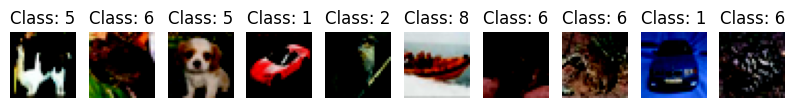

In [6]:
# 6. 데이터 확인하기 (2)
pltsize = 1                                             # 출력 이미지 크기 설정
plt.figure(figsize=(10 * pltsize, pltsize))             # 전체 그림 크기 설정 (가로로 10개 이미지)

for i in range(10):                                     # 처음 10개 이미지에 대해 반복
    plt.subplot(1, 10, i + 1)                           # 1행 10열의 서브플롯 중 i번째 위치
    plt.axis('off')                                     # 축(좌표) 숨기기
    plt.imshow(np.transpose(x_train[i],(1,2,0)))        # (C,H,W) → (H,W,C)로 변환 후 이미지 출력
    plt.title('Class: ' + str(y_train[i].item()))       # 해당 이미지의 클래스(숫자 라벨) 표시

In [ ]:
# 7. 파이토치 내에서 제공하는 ResNet34 모델 불러온 후 fc층 추가 및 Output 크기 설정 

import torchvision.models as models 

# ImageNet으로 사전학습 되지 않은 특수한 Initializer로 랜덤 샘플링된 파라미터를 이용하는 resnet34 모델 구조만 불러옴(옛날 코드 작성 방식) 
model = models.resnet34(pretrained=False) 

# 최신 문법 
# model = resnet34(weights=None) 


num_ftrs = model.fc.in_features  # resnet34 모델 완전 연결층의 입력값인 512를 저장
model.fc = nn.Linear(num_ftrs,10) # 기존 resnet34 모델의 완전연결층(512개 입력 1000개 분류) 대신 512개 입력, 10개 분류하는 완전연결층으로 교체  
model = model.cuda() # 학습을 GPU에서 수행하기 위해 모델을 CUDA 디바이스로 이동

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 모델의 파라미터를 Adam 최적화 알고리즘으로 업데이트하도록 설정 (학습률 0.001)
criterion = nn.CrossEntropyLoss()

# Warning (코드 작성 옜날 방식 경고 발생)

#  /home/centa/miniconda3/envs/firstproject/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
#  warnings.warn(
#/home/centa/miniconda3/envs/firstproject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
#  warnings.warn(msg)




/home/centa/miniconda3/envs/firstproject/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/centa/miniconda3/envs/firstproject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
# 7-(1) 파이토치 내에서 제공하는 ResNet34 모델 불러온 후 fc층 추가 및 Output 크기 설정(최신 문법)

# 사전학습 안쓰는 경우 
# from torchvision.models import resnet34

# model = resnet34(weights=None)

# 사전학습 사용하는 경우 

# from torchvision.models import resnet34, ResNet34_Weights

# model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)


# num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs,10)
# model = model.cuda()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  

# criterion = nn.CrossEntropyLoss()





In [8]:
# 8. NET 모델 학습을 진행하며 학습 데이터 대한 모델 성능을 확인하는 함수 정의 

def train(Epoch,model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image=image.to(DEVICE)
        label=label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output,label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {Epoch} [{batch_idx*len(image)}/{len(train_loader.dataset)}({100. * batch_idx / len(train_loader):.0f}%)]\tTrain Loss: {loss.item():.6f}")
        

In [9]:
# 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0 
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy =100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy  


In [10]:
# 10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기 
for Epoch in range(1,EPOCHS+1):
    train(Epoch,model,train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH]: {Epoch}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} %\n")


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.757499
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.590488
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.921914
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 1.435062
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.138997
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 1.399613
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 1.184268
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 1.070745

[EPOCH]: 1, 	Test Loss: 0.0520, 	Test Accuracy: 50.72 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 1.586656
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.234926
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.096222
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 1.450847
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 1.238322
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 0.852153
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 1.255489
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 1.248889

[EPOCH]: 2, 	Test Loss: 0.0310, 	Test Accuracy: 66.02 %

Train Epoch: 3 [

In [ ]:
# ImageNet 데이터로 학습된 ResNet34 모델을 불러온 후 Fine-tuning 해보기 

from torchvision.models import resnet34
# from torchvision.models import ResNet34_Weights

model = resnet34(pretrained=True)  # ImageNet 데이터로 사전학습된 파라미터를 resnet34모델에 적용해 불러옴
# model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)  # 최신문법


num_ftrs = model.fc.in_features # resnet34 모델 완전 연결층의 입력값인 512를 저장
model.fc = nn.Linear(num_ftrs,10) # 기존 resnet34 모델의 완전연결층(512개 입력 1000개 분류) 대신 512개 입력, 10개 분류하는 완전연결층으로 교체  
model = model.cuda() # 학습을 GPU에서 수행하기 위해 모델을 CUDA 디바이스로 이동

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # 모델의 파라미터를 Adam 최적화 알고리즘으로 업데이트하도록 설정 (학습률 0.001)


criterion = nn.CrossEntropyLoss()                           # ***중요 주의점***
                                                            # 분류 문제(CIFAR-10)에서는 반드시 CrossEntropyLoss를 사용해야 함
                                                            # 이전에 오토인코더 코드에서 MSELoss를 그대로 가져오면
                                                            #   - 모델 출력 크기(배치×10)와 라벨 크기(배치)가 맞지 않아
                                                            #   - RuntimeError: tensor size mismatch 오류가 발생함
                                                            # CrossEntropyLoss는 정수 라벨을 자동으로 처리하며
                                                            # 내부적으로 softmax + NLLLoss가 결합된 형태로 동작함


# 10. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인하기 
for Epoch in range(1,EPOCHS+1):
    train(Epoch,model,train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print(f"\n[EPOCH]: {Epoch}, \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} %\n")

/home/centa/miniconda3/envs/firstproject/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
1.7%

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/centa/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100.0%


Train Epoch: 1 [0/50000(0%)]	Train Loss: 2.663620
Train Epoch: 1 [6400/50000(13%)]	Train Loss: 1.285280
Train Epoch: 1 [12800/50000(26%)]	Train Loss: 1.012173
Train Epoch: 1 [19200/50000(38%)]	Train Loss: 0.857720
Train Epoch: 1 [25600/50000(51%)]	Train Loss: 1.138162
Train Epoch: 1 [32000/50000(64%)]	Train Loss: 0.792583
Train Epoch: 1 [38400/50000(77%)]	Train Loss: 0.666638
Train Epoch: 1 [44800/50000(90%)]	Train Loss: 0.864147

[EPOCH]: 1, 	Test Loss: 0.0281, 	Test Accuracy: 69.23 %

Train Epoch: 2 [0/50000(0%)]	Train Loss: 0.952227
Train Epoch: 2 [6400/50000(13%)]	Train Loss: 1.103224
Train Epoch: 2 [12800/50000(26%)]	Train Loss: 1.055037
Train Epoch: 2 [19200/50000(38%)]	Train Loss: 0.591398
Train Epoch: 2 [25600/50000(51%)]	Train Loss: 0.800712
Train Epoch: 2 [32000/50000(64%)]	Train Loss: 0.621249
Train Epoch: 2 [38400/50000(77%)]	Train Loss: 0.727792
Train Epoch: 2 [44800/50000(90%)]	Train Loss: 0.585319

[EPOCH]: 2, 	Test Loss: 0.0218, 	Test Accuracy: 76.45 %

Train Epoch: 3 [